In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


### Imports

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from tensorflow.keras.layers import  Dropout, Activation
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy
from tensorflow.keras.utils import plot_model, to_categorical
import warnings

warnings.filterwarnings(action='ignore')

import glob
import random
import cv2
from random import shuffle

Using TensorFlow backend.


In [4]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xvzf images.tar.gz && tar -xvzf annotations.tar.gz
!rm  images/*.mat

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
annotations/trimaps/pomeranian_180.png
annotations/trimaps/._pomeranian_181.png
annotations/trimaps/pomeranian_181.png
annotations/trimaps/._pomeranian_182.png
annotations/trimaps/pomeranian_182.png
annotations/trimaps/._pomeranian_183.png
annotations/trimaps/pomeranian_183.png
annotations/trimaps/._pomeranian_184.png
annotations/trimaps/pomeranian_184.png
annotations/trimaps/._pomeranian_185.png
annotations/trimaps/pomeranian_185.png
annotations/trimaps/._pomeranian_186.png
annotations/trimaps/pomeranian_186.png
annotations/trimaps/._pomeranian_187.png
annotations/trimaps/pomeranian_187.png
annotations/trimaps/._pomeranian_188.png
annotations/trimaps/pomeranian_188.png
annotations/trimaps/._pomeranian_189.png
annotations/trimaps/pomeranian_189.png
annotations/trimaps/._pomeranian_19.png
annotations/trimaps/pomeranian_19.png
annotations/trimaps/._pomeranian_190.png
annotations/trimaps/pomeranian_190.png
annotations/trimaps/._pomeranian_191.png
annota

### Generators

In [0]:
def image_generator(files, batch_size = 16, sz = (256, 256)):
  
  while True:
    batch = np.random.choice(files, size = batch_size)    
    batch_x = []
    batch_y = []
    
    for f in batch:
        mask = Image.open(f'annotations/trimaps/{f[:-4]}.png')
        mask = np.array(mask.resize(sz))
        mask[mask >= 2] = 0 
        mask[mask != 0 ] = 1
        
        batch_y.append(mask)

        raw = Image.open(f'images/{f}')
        raw = raw.resize(sz)
        raw = np.array(raw)

        if len(raw.shape) == 2:
          raw = np.stack((raw,)*3, axis=-1)

        else:
          raw = raw[:,:,0:3]

        batch_x.append(raw)

    batch_x = np.array(batch_x)/255.
    batch_y = np.array(batch_y)
    batch_y = to_categorical(batch_y)

    yield (batch_x, batch_y)          

In [0]:
batch_size = 16 

all_files = os.listdir('images')
shuffle(all_files)

split = int(0.95 * len(all_files))

train_files = all_files[0:split]
test_files  = all_files[split:]

train_generator = image_generator(train_files, batch_size = batch_size)
test_generator  = image_generator(test_files, batch_size = batch_size)

In [0]:
x, y= next(train_generator)

In [8]:
print (x.shape, y.shape)

(16, 256, 256, 3) (16, 256, 256, 2)


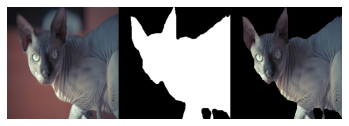

In [9]:
plt.axis('off')
img = x[0]

msk = y[0]
msk = msk[:,:,1]
msk = np.stack((msk,)*3, axis=-1)

plt.imshow( np.concatenate([img, msk, img*msk], axis = 1))

### IoU metric

The intersection over union (IoU) metric is a simple metric used to evaluate the performance of a segmentation algorithm. Given two masks $x_{true}, x_{pred}$ we evaluate 

$$IoU = \frac{y_{true} \cap y_{pred}}{y_{true} \cup y_{pred}}$$

In [0]:
def dice_coef(y_true, y_pred, smooth=1):
    y_pred = K.argmax(y_pred, axis=-1)
    y_true = y_true[:,:,:,1]
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    y_true_f = K.cast(y_true_f, 'float32')
    y_pred_f = K.cast(y_pred_f, 'float32')

    intersection = K.sum(y_true_f * y_pred_f)

    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    smooth = 1.

    y_pred = K.argmax(y_pred, axis=-1)
    y_true = y_true[:,:,:,1]    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    y_true_f = K.cast(y_true_f, 'float32')
    y_pred_f = K.cast(y_pred_f, 'float32')
    
    intersection = y_true_f * y_pred_f

    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    
    return -(K.log(score))

def bce_dice_loss(y_true, y_pred):
    return categorical_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

In [0]:
def block_residual(x, nKernels):
  identity = x
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(nKernels, 3, activation=None, kernel_initializer='he_normal', padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(nKernels, 3, activation=None, kernel_initializer='he_normal', padding='same')(x)
  
  return x + identity

### Model

In [0]:
from tensorflow.keras.layers import concatenate

def mnet(sz = (256, 256, 3)):
  x = Input(sz)
  input_feature = Conv2D(16, (1,1), activation='relu')(x)

  L_Leg_1 = MaxPooling2D((2,2)) (input_feature)
  L_Leg_2 = MaxPooling2D((2,2)) (L_Leg_1)
  L_Leg_3 = MaxPooling2D((2,2)) (L_Leg_2)

  layer_1_1 = Conv2D(16, (3, 3), activation='relu', padding='same')(input_feature)
  layer_1_1 = BatchNormalization()(layer_1_1)
  layer_1_c = concatenate([layer_1_1, input_feature])

  layer_1_2 = Conv2D(32, (3, 3), activation='relu', padding='same')(layer_1_c)
  layer_1_2 = BatchNormalization()(layer_1_2)
  layer_1_p = MaxPooling2D((2, 2)) (layer_1_2)

  layer_2_1 = concatenate([L_Leg_1, layer_1_p])

  layer_2_2 = Conv2D(32, (3, 3), activation='relu', padding='same') (layer_2_1)
  layer_2_2 = BatchNormalization()(layer_2_2)
  layer_2_c = concatenate([layer_2_2, layer_1_p])

  layer_2_3 = Conv2D(48, (3, 3), activation='relu', padding='same')(layer_2_c)
  layer_2_3 = BatchNormalization()(layer_2_3)
  layer_2_p = MaxPooling2D((2, 2)) (layer_2_3)

  layer_3_1 = concatenate([L_Leg_2, layer_2_p])

  layer_3_2 = Conv2D(48, (3, 3), activation='relu', padding='same') (layer_3_1)
  layer_3_2 = BatchNormalization()(layer_3_2)
  layer_3_c = concatenate([layer_3_2, layer_2_p])

  layer_3_3 = Conv2D(64, (3, 3), activation='relu', padding='same') (layer_3_c)
  layer_3_3 = BatchNormalization()(layer_3_3)
  layer_3_p = MaxPooling2D((2, 2)) (layer_3_3)

  layer_4_1 = concatenate([L_Leg_3, layer_3_p])

  layer_4_2 = Conv2D(64, (3, 3), activation='relu', padding='same') (layer_4_1)
  layer_4_2 = BatchNormalization()(layer_4_2)
  layer_4_c = concatenate([layer_4_2, layer_3_p])

  layer_4_3 = Conv2D(128, (3, 3), activation='relu', padding='same') (layer_4_c)
  layer_4_3 = BatchNormalization()(layer_4_3)

  layer_4_4 = Conv2D(64, (3, 3), activation='relu', padding='same') (layer_4_3)
  layer_4_4 = BatchNormalization()(layer_4_4)

  layer_5_u = UpSampling2D((2, 2)) (layer_4_4)
  layer_5_1 = concatenate([layer_5_u, layer_3_3])

  layer_5_2 = Conv2D(64, (3, 3), activation='relu', padding='same') (layer_5_1)
  layer_5_2 = BatchNormalization()(layer_5_2)
  layer_5_c = concatenate([layer_5_2, layer_5_u])

  layer_5_3 = Conv2D(48, (3, 3), activation='relu', padding='same') (layer_5_c)
  layer_5_3 = BatchNormalization()(layer_5_3)

  layer_6_u = UpSampling2D((2, 2)) (layer_5_3)
  layer_6_1 = concatenate([layer_6_u, layer_2_3])

  layer_6_2 = Conv2D(48, (3, 3), activation='relu', padding='same') (layer_6_1)
  layer_6_2 = BatchNormalization()(layer_6_2)
  layer_6_c = concatenate([layer_6_2, layer_6_u])

  layer_6_3 = Conv2D(32, (3, 3), activation='relu', padding='same') (layer_6_c)
  layer_6_3 = BatchNormalization()(layer_6_3)

  layer_7_u = UpSampling2D((2, 2)) (layer_6_3)
  layer_7_1 = concatenate([layer_7_u, layer_1_2])

  layer_7_2 = Conv2D(32, (3, 3), activation='relu', padding='same') (layer_7_1)
  layer_7_2 = BatchNormalization()(layer_7_2)
  layer_7_c = concatenate([layer_7_2, layer_7_u])

  layer_7_3 = Conv2D(16, (3, 3), activation='relu', padding='same') (layer_7_c)
  layer_7_3 = BatchNormalization()(layer_7_3)

  R_leg_1 = UpSampling2D((8, 8)) (layer_4_4)
  R_leg_2 = UpSampling2D((4, 4)) (layer_5_3)
  R_leg_3 = UpSampling2D((2, 2)) (layer_6_3)

  final_layer = concatenate([layer_7_3, R_leg_3, R_leg_2, R_leg_1])

  outputs = Conv2D(2, 1, activation='softmax') (final_layer)

  model = Model(inputs=[x], outputs=[outputs])
  model.compile(optimizer = 'rmsprop', loss = bce_dice_loss, metrics = [dice_coef])

  return model

In [13]:
model = mnet()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
def build_callbacks():
        checkpointer = ModelCheckpoint(filepath='unet.h5', verbose=0, save_best_only=True, save_weights_only=True)
        callbacks = [checkpointer, PlotLearning()]

        return callbacks

class PlotLearning(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('dice_coef'))
        self.val_acc.append(logs.get('val_dice_coef'))
        self.i += 1
        print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),
        'mean_dsc=',logs.get('dice_coef'),'val_mean_dsc=',logs.get('val_dice_coef'))
        
        path = np.random.choice(test_files)

        raw = Image.open(f'images/{path}')
        raw = np.array(raw.resize((256, 256)))/255.
        raw = raw[:,:,0:3]
        
        pred = model.predict(np.expand_dims(raw, 0))
      
        msk = np.argmax(pred, axis=-1)
        msk  = msk.squeeze()
        msk = np.stack((msk,)*3, axis=-1)
        
        combined = np.concatenate([raw, msk, raw* msk], axis = 1)
        
        plt.axis('off')
        plt.imshow(combined)
        plt.show()

In [15]:
train_steps = len(train_files) //batch_size
test_steps = len(test_files) //batch_size

print (train_steps, test_steps)

438 23


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
i= 1 loss= 0.9258464488400716 val_loss= 0.9245360208594281 mean_dsc= 0.63129914 val_mean_dsc= 0.62814313


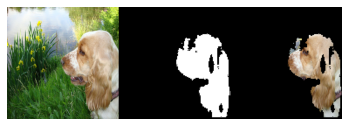

i= 2 loss= 0.5436489586824695 val_loss= 0.44752445687418396 mean_dsc= 0.7798221 val_mean_dsc= 0.8146356


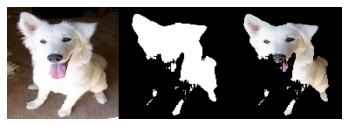

i= 3 loss= 0.45926953471142407 val_loss= 0.5401177380395972 mean_dsc= 0.81641155 val_mean_dsc= 0.77484727


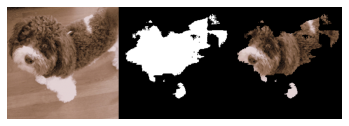

i= 4 loss= 0.4064806824949778 val_loss= 0.5015168423238008 mean_dsc= 0.83820367 val_mean_dsc= 0.78714067


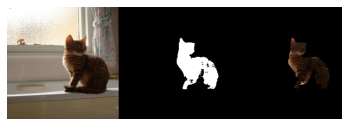

i= 5 loss= 0.36329434424230495 val_loss= 1.212455954240716 mean_dsc= 0.85393786 val_mean_dsc= 0.504039


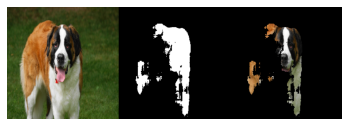

i= 6 loss= 0.3431868067342941 val_loss= 0.38907488662263623 mean_dsc= 0.8637831 val_mean_dsc= 0.84738535


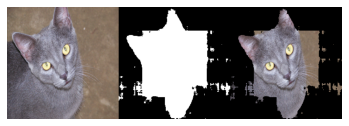

i= 7 loss= 0.3243406557533295 val_loss= 0.3871726989746094 mean_dsc= 0.8699262 val_mean_dsc= 0.85075647


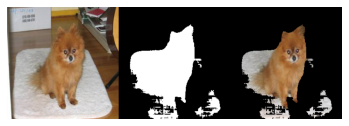

i= 8 loss= 0.3037207759746678 val_loss= 0.3091383757798568 mean_dsc= 0.8778717 val_mean_dsc= 0.8816319


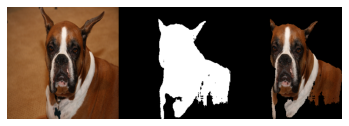

i= 9 loss= 0.29569989102616157 val_loss= 0.3423917008482892 mean_dsc= 0.8824917 val_mean_dsc= 0.8695031


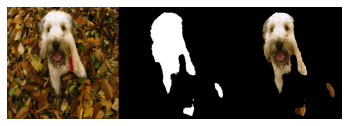

i= 10 loss= 0.2795241905810082 val_loss= 0.30576428317505383 mean_dsc= 0.8888961 val_mean_dsc= 0.88497734


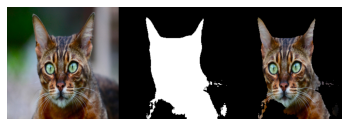

i= 11 loss= 0.2668243238370713 val_loss= 0.4053790426772574 mean_dsc= 0.89345527 val_mean_dsc= 0.8321734


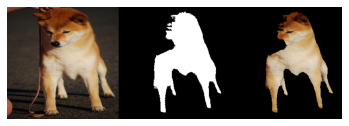

i= 12 loss= 0.2548882186957146 val_loss= 0.31188002552675165 mean_dsc= 0.89855224 val_mean_dsc= 0.87767434


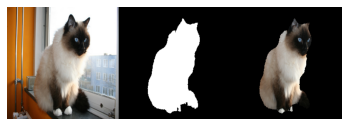

i= 13 loss= 0.2480464590602814 val_loss= 0.2737572219060815 mean_dsc= 0.9007689 val_mean_dsc= 0.89348894


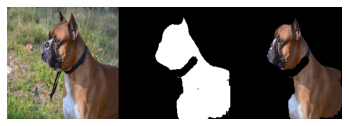

i= 14 loss= 0.23850821552279333 val_loss= 0.3891969154710355 mean_dsc= 0.9049281 val_mean_dsc= 0.8520289


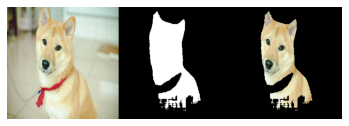

i= 15 loss= 0.2292953941579823 val_loss= 0.3053496330976486 mean_dsc= 0.9085649 val_mean_dsc= 0.88375044


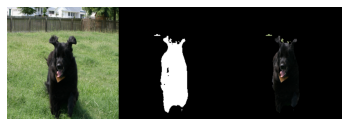

i= 16 loss= 0.22654376461353476 val_loss= 0.30370050085627515 mean_dsc= 0.90909374 val_mean_dsc= 0.8787066


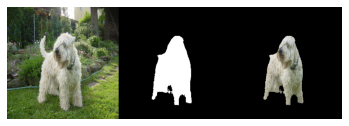

i= 17 loss= 0.21016570201067075 val_loss= 0.37523652677950653 mean_dsc= 0.91629344 val_mean_dsc= 0.84879744


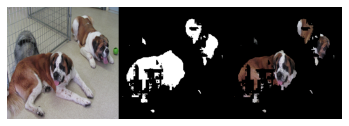

i= 18 loss= 0.20792118517775512 val_loss= 0.38591682068679645 mean_dsc= 0.9171886 val_mean_dsc= 0.847525


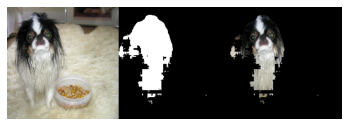

i= 19 loss= 0.20112910691529648 val_loss= 0.34097412746885547 mean_dsc= 0.91953826 val_mean_dsc= 0.87094706


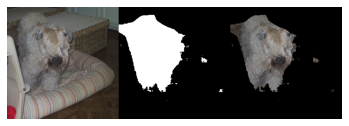

i= 20 loss= 0.1935484559704724 val_loss= 0.294694013569666 mean_dsc= 0.9228544 val_mean_dsc= 0.8835742


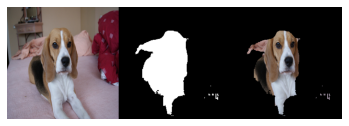

In [16]:
model.fit_generator(train_generator, 
                    epochs = 20, steps_per_epoch = train_steps, validation_data = test_generator, validation_steps = test_steps,
                    callbacks = build_callbacks(), verbose = 0)

# Testing

In [17]:
!wget http://r.ddmcdn.com/s_f/o_1/cx_462/cy_245/cw_1349/ch_1349/w_720/APL/uploads/2015/06/caturday-shutterstock_149320799.jpg -O test.jpg

--2020-05-13 10:07:47--  http://r.ddmcdn.com/s_f/o_1/cx_462/cy_245/cw_1349/ch_1349/w_720/APL/uploads/2015/06/caturday-shutterstock_149320799.jpg
Resolving r.ddmcdn.com (r.ddmcdn.com)... 13.224.12.41, 13.224.12.79, 13.224.12.69, ...
Connecting to r.ddmcdn.com (r.ddmcdn.com)|13.224.12.41|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63219 (62K) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>]  61.74K  --.-KB/s    in 0.01s   

2020-05-13 10:07:47 (5.69 MB/s) - ‘test.jpg’ saved [63219/63219]



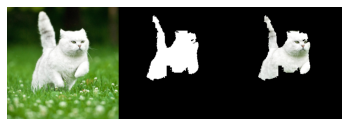

In [18]:
raw = Image.open('test.jpg')
raw = np.array(raw.resize((256, 256)))/255.
raw = raw[:,:,0:3]

pred = model.predict(np.expand_dims(raw, 0))

msk = np.argmax(pred, axis=-1)
msk  = msk.squeeze()
msk = np.stack((msk,)*3, axis=-1)

combined = np.concatenate([raw, msk, raw* msk], axis = 1)

plt.axis('off')
plt.imshow(combined)
plt.show()

# References


1.   http://deeplearning.net/tutorial/unet.html
2.   https://github.com/ldenoue/keras-unet

